In [2]:
import pandas as pd
import numpy as np
import os

In [6]:
#!pip install mplcyberpunk --upgrade
#!pip install split-folders

## Importation des libraries

In [3]:
import pathlib, os, random, mplcyberpunk
import splitfolders
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPool2D, Conv2D, Activation

In [13]:
base_path = '.\TB_Chest_Radiography_Database'
base_path = pathlib.Path(base_path)
base_path

WindowsPath('TB_Chest_Radiography_Database')

In [14]:
# Permet la partition en train (0.7) test (0.15) et validation(0.15)
splitfolders.ratio(base_path, output='X_ray_Imgs', seed = 123, ratio= (0.7,0.15,0.15), group_prefix= None)


Copying files: 4200 files [01:36, 43.68 files/s] 


In [15]:
#NormalImgs = [fn for fn in os.listdir('./TB_Chest_Radiography_Database/Normal') if fn.endswith('.png')]


### Definitions des dossiers Normale et tuberculose

In [4]:

labels = []
NormalImgs =[]
for fn in os.listdir("./TB_Chest_Radiography_Database/Normal/"):
    if fn.endswith('.png'):
        NormalImgs.append(fn)
        labels.append(0)

TuberculosisImgs = []
for fn in os.listdir("./TB_Chest_Radiography_Database/Tuberculosis/"):
    if fn.endswith('.png'):
        TuberculosisImgs.append(fn)
        labels.append(1)

In [5]:
len(TuberculosisImgs), len(NormalImgs)

(700, 3500)

## Normalisation et definition

In [6]:
from random import shuffle


batch_size = 64
img_height, img_width = 200,200
input_shape = (img_height, img_width, 3)

datagen = ImageDataGenerator(rescale=1.0/255)

train_set = datagen.flow_from_directory('./X_ray_Imgs/train/', target_size= (200,200),
                                        batch_size= batch_size, class_mode ='categorical', subset = 'training')

test_set = datagen.flow_from_directory('./X_ray_Imgs/test/', target_size=(200,200), batch_size = batch_size,
                                        class_mode = 'categorical', shuffle = False)

val_set = datagen.flow_from_directory("./X_ray_Imgs/val/", target_size=(200,200), batch_size= batch_size,
                                        class_mode = 'categorical', shuffle = False)

Found 2939 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
Found 630 images belonging to 2 classes.


## Construction du modele 

In [7]:
class Model_Img(tf.keras.Model):
    def __init__(self):
        super(Model_Img, self).__init__()

        self.C1 = Conv2D(32, (3 * 3), input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPool2D(2, padding='same')
        self.Dr1 = Dropout(0.2)
        
        
        self.C2 = Conv2D(64, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPool2D(2, padding='same')
        self.Dr2 = Dropout(0.3)
        
        self.F1 = Flatten()
        self.D1 = Dense(32, activation='relu')
        self.B3 = BatchNormalization()
        self.D2 = Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2())
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        x = self.Dr1(x)
        
        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr2(x)
        
        x = self.F1(x)
        x = self.D1(x)
        x = self.B3(x)
        y = self.D2(x)
        
        return y



In [8]:
model = Model_Img()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
                loss ='binary_crossentropy', metrics=["accuracy"])

In [9]:
checkpoint_save_path = './model/'

# if os.path.exists(checkpoint_save_path + '.index'):
#     model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_best_only=True, 
                                                 save_weights_only=True)

# history = model.fit(train_ds, validation_data=(val_ds), epochs=5, batch_size=32, callbacks=[cp_callback])

In [10]:
dir_save_model = "./model/"
model_name = "weights-Best_.hdf5"
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(dir_save_model, model_name), monitor='val_accuracy', 
verbose=0, save_best_only= True, save_weight_only = True, mode='max')

### Entrainement du modele

In [11]:

history = model.fit(train_set, validation_data=val_set, epochs=7, batch_size=32,
                    callbacks = [cp_callback]) #callbacks=[cp_callback])



Epoch 1/7
46/46 [==============================] - 20034s 444s/step - loss: 0.3771 - accuracy: 0.9054 - val_loss: 0.3111 - val_accuracy: 0.8841
Epoch 2/7
46/46 [==============================] - 1743s 38s/step - loss: 0.2400 - accuracy: 0.9622 - val_loss: 0.2609 - val_accuracy: 0.9349
Epoch 3/7
46/46 [==============================] - 1649s 36s/step - loss: 0.1717 - accuracy: 0.9806 - val_loss: 0.4656 - val_accuracy: 0.8508
Epoch 4/7
46/46 [==============================] - 1755s 38s/step - loss: 0.1411 - accuracy: 0.9854 - val_loss: 0.2276 - val_accuracy: 0.9254
Epoch 5/7
46/46 [==============================] - 1555s 34s/step - loss: 0.1268 - accuracy: 0.9837 - val_loss: 0.9573 - val_accuracy: 0.8317
Epoch 6/7
46/46 [==============================] - 1819s 40s/step - loss: 0.1047 - accuracy: 0.9895 - val_loss: 0.2115 - val_accuracy: 0.9254
Epoch 7/7
46/46 [==============================] - 2566s 56s/step - loss: 0.1127 - accuracy: 0.9847 - val_loss: 0.5518 - val_accuracy: 0.8762


In [12]:
model.summary()

Model: "model__img"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  7808      
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  1

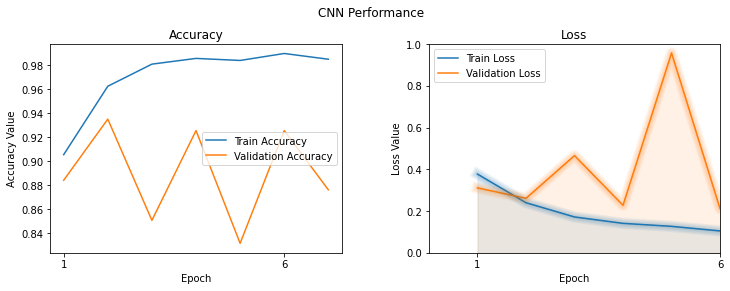

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
t = f.suptitle("CNN Performance  " , fontsize = 12)
f.subplots_adjust(top=0.85, wspace = 0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
#Figure 1
ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1= ax1.legend(loc="best")
mplcyberpunk.add_glow_effects()

#Figure 2
ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
mplcyberpunk.add_glow_effects()

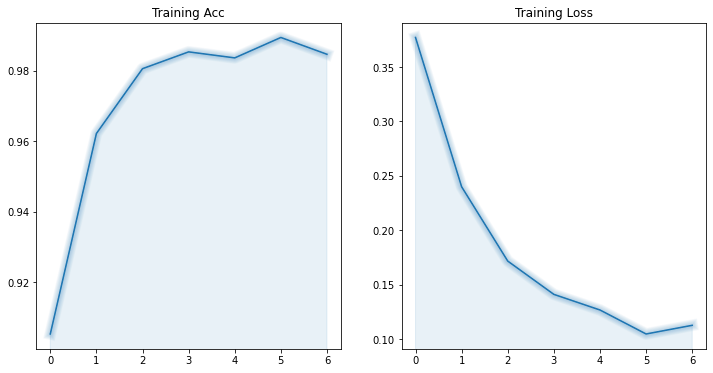

In [14]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')
mplcyberpunk.add_glow_effects()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
mplcyberpunk.add_glow_effects()

plt.show()

In [15]:
pred = model.predict(test_set)
print(model.evaluate(test_set))


10/10 [==============================] - 81s 8s/step - loss: 0.5634 - accuracy: 0.8685
[0.5633910298347473, 0.8684627413749695]
